# Import relevant libraries

In [70]:
#set up
import json
import gzip
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('fivethirtyeight')

# Read data

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for i in g:
        yield json.loads(i)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient = 'index')

In [3]:
ab_r = getDF('All_Beauty.json.gz')
ab_m = getDF('meta_All_Beauty.json.gz')
lb_r = getDF('Luxury_Beauty.json.gz')
lb_m = getDF('meta_Luxury_Beauty.json.gz')

In [4]:
# merge the data

ab_merged = pd.merge(ab_r, ab_m, how='inner', on ='asin')
lb_merged = pd.merge(lb_r, lb_m, how='inner', on ='asin')

# Data Cleaning

In [5]:
# data cleaning
to_drop = ['vote','reviewText', 'reviewerName', 'summary','image_x', 'image_y', 'description', 'details']
ab_merged.drop(to_drop, inplace=True, axis=1)
lb_merged.drop(to_drop, inplace=True, axis=1)

In [6]:
## drop NaN

lb_merged_non = lb_merged.dropna(subset=['price'])
ab_merged_non = ab_merged.dropna(subset=['price'])

In [78]:
## Convert unixReviewTime to the datetime
ab_merged_non['DatetimeIndex'] = pd.to_datetime(ab_merged_non['unixReviewTime'],unit='s')
lb_merged_non['DatetimeIndex'] = pd.to_datetime(lb_merged_non['unixReviewTime'],unit='s')

/Users/zhihuipan/anaconda3/envs/Data_visualisation/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zhihuipan/anaconda3/envs/Data_visualisation/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
## build a conver_currency function
def conver_currency(value):
    """
    =============================
    Argument: string
    convert currency 
    - remove $
    - convert string to float
    
    Return: float
    =============================
    
    """
    new_value = value.replace(',','').replace('$','')
    return np.float(new_value)

## build a to float function
def to_float(x):
    return np.float(x)

## build a function to remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#Identify outliers
def detect_outlier(data_1):
    outliers=[]
    threshold=4
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [110]:
## convert string to float
ab_merged_non['price'] = ab_merged_non['price'].apply(conver_currency)
lb_merged_non['price'] = lb_merged_non['price'].apply(conver_currency)

# Due to one of the lines having a range in price, namely '12.90 - 169.95', the function skips this value
## Maybe we can try to drop these values

/Users/zhihuipan/anaconda3/envs/Data_visualisation/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## extract products that have reviews over 6 months

In [13]:
# Find the lastest date
lb_edate = min(lb_merged_non['DatetimeIndex'])
lb_ldate = max(lb_merged_non['DatetimeIndex'])
lb_threshold = lb_ldate - datetime.timedelta(days=180)
ab_edate = min(ab_merged_non['DatetimeIndex'])
ab_ldate = max(ab_merged_non['DatetimeIndex'])
ab_threshold = ab_ldate - datetime.timedelta(days=180)

In [14]:
# creat start_date and end_date column 
ab_sdate = ab_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
ab_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)
lb_sdate = lb_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
lb_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)

In [15]:
# Defining and applying 6 months time span
cal_6months = lambda x: (x+ datetime.timedelta(days=180))
ab_sdate['end_date'] = ab_sdate['start_date'].apply(cal_6months)
lb_sdate['end_date'] = lb_sdate['start_date'].apply(cal_6months)

In [16]:
# merge the dataframe 
df_lb = pd.merge(lb_merged_non, lb_sdate, how='inner', on ='asin')
df_ab = pd.merge(ab_merged_non, ab_sdate, how='inner', on ='asin')

In [17]:
# Exclude products whose first score has been posted by less than six months
df_lb = df_lb[df_lb['start_date'] < lb_threshold]
df_ab = df_ab[df_ab['start_date'] < ab_threshold]

In [18]:
# the very first reviews up to six months later
df_lb = df_lb[df_lb['DatetimeIndex'] < df_lb['end_date']]
df_ab = df_ab[df_ab['DatetimeIndex'] < df_ab['end_date']]


In [19]:
# Calculate difference in days between first and last review of each product
df_lb['#Days'] = df_lb['DatetimeIndex'] - df_lb['start_date']
df_lb['#Days'] = df_lb['#Days'].apply(lambda x: x.days)
df_ab['#Days'] = df_ab['DatetimeIndex'] - df_ab['start_date']
df_ab['#Days'] = df_ab['#Days'].apply(lambda x: x.days)

In [20]:
#Max date within 6 months
series_lb = df_lb.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_lb.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)
series_ab = df_ab.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_ab.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)

df_lb = pd.merge(df_lb, series_lb, how='inner', on ='asin')
df_ab = pd.merge(df_ab, series_ab, how='inner', on ='asin')

# calculate between first review and last reviws
df_lb['review_gap'] = df_lb['last_review'] - df_lb['start_date']
df_lb['review_gap'] = df_lb['review_gap'].apply(lambda x: x.days)
df_ab['review_gap'] = df_ab['last_review'] - df_ab['start_date']
df_ab['review_gap'] = df_ab['review_gap'].apply(lambda x: x.days)

In [102]:
df_ab.T

asin                                                   014789302X  \
review_year                                                  2016   
review_month                                                   8    
review_day                                                     5    
index                                                           0   
DatetimeIndex                                 2016-08-05 00:00:00   
overall                                                         4   
verified                                                     True   
reviewTime                                             08 5, 2016   
reviewerID                                         A3CKVF2ZR1CBO0   
unixReviewTime                                         1470355200   
style                                                         NaN   
title           12 Pc BLUE HEAVEN KAJAL"HERBAL kajal With VITA...   
brand                                                  BLUE HEAVE   
rank                                 100,425inBeautyPersonalCare(   
main_cat                                               All Beauty   
also_view       [B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...   
also_buy        [B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...   
price                                                       $6.45   
similar_item                                                  NaN   
feature                                                       NaN   
tech1                                                         NaN   
date                                                          NaN   
start_date                                    2016-03-26 00:00:00   
end_date                                      2016-09-22 00:00:00   
#Days                                                         132   
last_review                                   2016-08-05 00:00:00   
review_gap                                                    132   
#Weeks                                                         18   
weight                                                          1   
reviews                                                         1   
average                                                         4   

asin                                                               \
review_year                                                         
review_month                                                   7    
review_day                                                     29   
index                                                           1   
DatetimeIndex                                 2016-07-29 00:00:00   
overall                                                         5   
verified                                                     True   
reviewTime                                            07 29, 2016   
reviewerID                                         A3IFT6SR16SAYU   
unixReviewTime                                         1469750400   
style                                                         NaN   
title           12 Pc BLUE HEAVEN KAJAL"HERBAL kajal With VITA...   
brand                                                  BLUE HEAVE   
rank                                 100,425inBeautyPersonalCare(   
main_cat                                               All Beauty   
also_view       [B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...   
also_buy        [B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...   
price                                                       $6.45   
similar_item                                                  NaN   
feature                                                       NaN   
tech1                                                         NaN   
date                                                          NaN   
start_date                                    2016-03-26 00:00:00   
end_date                                      2016-09-22 00:00:00   
#Days                                                         125 

## Dataset for plot 4

In [21]:
#dataset for plot 4
df4_lb=pd.DataFrame(df_lb.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())
df4_ab=pd.DataFrame(df_ab.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())

In [47]:
df4_lb

,asin,review_gap,overall,average pace,round avg pace
0,B00004U9V2,159,4,39.750000,40.0
1,B00005A77F,173,4,43.250000,43.0
2,B00005NDTD,0,2,0.000000,0.0
3,B00005V50B,0,2,0.000000,0.0
4,B00005V50C,0,2,0.000000,0.0
...,...,...,...,...,...
6747,B01HIQEOLO,174,4,43.500000,44.0
6748,B01HIQHQU0,145,5,29.000000,29.0
6749,B01HIQIEYC,165,9,18.333333,18.0
6750,B01HJ2UY0W,0,1,0.000000,0.0


In [22]:
# Calculate average pace based on the gap between first and last review and number of reviews in that period
df4_lb['average pace']=df4_lb['review_gap']/df4_lb['overall']
df4_ab['average pace']=df4_ab['review_gap']/df4_ab['overall']
# Round average pace in order to group the data for the average trend line
df4_lb['round avg pace'] = df4_lb['average pace'].round()
df4_ab['round avg pace'] = df4_ab['average pace'].round()
df4_lb_avg = pd.DataFrame(df4_lb.groupby(by=['round avg pace'], as_index=False)['overall'].aggregate(np.sum))
df4_ab_avg = pd.DataFrame(df4_ab.groupby(by=['round avg pace'], as_index=False)['overall'].aggregate(np.sum))
# Temporary Dataframe
df4_lb_com = df4_lb.groupby(by=['round avg pace'], as_index=False)['overall'].count()
df4_ab_com = df4_ab.groupby(by=['round avg pace'], as_index=False)['overall'].count()
# Convert int to float
df4_lb_avg['round avg pace'] = df4_lb_avg['round avg pace'].apply(to_float)
df4_ab_avg['round avg pace'] = df4_ab_avg['round avg pace'].apply(to_float)

In [23]:
df4_ab_com

,round avg pace,overall
0,0.0,6441
1,1.0,28
2,2.0,52
3,3.0,46
4,4.0,71
...,...,...
86,86.0,31
87,87.0,8
88,88.0,21
89,89.0,7


In [48]:
# Calculate average number of reviews per product to use in showing general trend
df4_lb_avg['average count']=df4_lb_avg['overall']/df4_lb_com['overall']
df4_ab_avg['average count']=df4_ab_avg['overall']/df4_ab_com['overall']

In [49]:
df4_lb_avg

,round avg pace,overall,average count
0,0.0,5049,1.780952
1,1.0,1284,47.555556
2,2.0,1454,19.917808
3,3.0,998,28.514286
4,4.0,1516,21.657143
...,...,...,...
86,86.0,46,2.000000
87,87.0,20,2.000000
88,88.0,40,2.000000
89,89.0,18,2.000000


## Dataset for plot1 

In [25]:
# Calculating number of weeks to use as x axis for visualisation
df_lb['#Weeks'] = df_lb['#Days'].apply(lambda x: int(x/7))
df_ab['#Weeks'] = df_ab['#Days'].apply(lambda x: int(x/7))

In [26]:
# set the datetime as indext
df_lb.set_index('DatetimeIndex', inplace=True)
df_ab.set_index('DatetimeIndex', inplace=True)
# Groupby 
df_lb_g=pd.DataFrame(df_lb.groupby(['asin','#Weeks'])['overall'].count())
df_ab_g=pd.DataFrame(df_ab.groupby(['asin','#Weeks'])['overall'].count())

In [50]:
df_ab_g

,asin,#Weeks,overall
0,014789302X,0,1
1,014789302X,8,1
2,014789302X,12,1
3,014789302X,17,1
4,014789302X,18,1
...,...,...,...
23850,B01HJ84SGM,0,1
23851,B01HJ84SGM,2,1
23852,B01HJ84SGM,15,1
23853,B01HJ84SGM,21,1


In [27]:
# Fill NaN with 0 and then replace with 'No brand'
df_ab['brand']=df_ab['brand'].fillna(value= 0)
df_lb['brand']=df_lb['brand'].fillna(value= 0)
df_ab['brand']=df_ab['brand'].replace(0, 'No brand')
df_lb['brand']=df_lb['brand'].replace(0, 'No brand')
df_lb

,overall,verified,reviewTime,reviewerID,asin,unixReviewTime,style,title,also_buy,rank,...,main_cat,price,brand,feature,start_date,end_date,#Days,last_review,review_gap,#Weeks
DatetimeIndex,,,,,,,,,,,,,,,,,,,,,
2010-06-15,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,159,2010-06-15,159,22
2010-06-15,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,159,2010-06-15,159,22
2010-01-07,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,0,2010-06-15,159,0
2010-01-07,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,0,2010-06-15,159,0
2013-04-22,4.0,True,"04 22, 2013",A3TXIN5QWZMHCH,B00005A77F,1366588800,NaN,"Crabtree & Evelyn Hand Soap, Gardeners, 10.1 f...",NaN,NaN,...,Luxury Beauty,$15.99,No brand,NaN,2012-10-31,2013-04-29,173,2013-04-22,173,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-21,3.0,True,"07 21, 2017",A1UKPVDCE6VGN,B01HIIO7Q4,1500595200,{'Size:': ' 1.6 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,170,2017-07-21,170,24
2017-04-15,5.0,True,"04 15, 2017",AOUIF4QULQVXO,B01HIIO7Q4,1492214400,{'Size:': ' 6.7 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,73,2017-07-21,170,10
2017-02-01,3.0,True,"02 1, 2017",AY8WT4WMDDUX0,B01HIIO7Q4,1485907200,{'Size:': ' 1.6 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,0,2017-07-21,170,0


In [28]:
# Create a new dataframe which measures the strength of each brand, namely number of reviews per brand
lb_brand = pd.DataFrame(df_lb.groupby(['brand','asin'])['overall'].count())
ab_brand = pd.DataFrame(df_ab.groupby(['brand','asin'])['overall'].count())
lb_brand = lb_brand.sort_values(by='overall', ascending=False)
ab_brand = ab_brand.sort_values(by='overall', ascending=False)
ab_brand

overall
brand         asin               
Italia-Deluxe B00VF344X0      502
No brand      B01B54XW54      322
OZ Naturals   B00NT0AR7E      290
TOULON        B00SQ3S6TA      256
Jubujub       B008U1Q4DI      243
...                           ...
No brand      B014I0FUFC        1
              B014HZT30G        1
              B014HIUKF0        1
Grafco        B000TESWFM        1
-417          B01ELTNOU8        1

[10882 rows x 1 columns]

In [29]:
#Reset index
df_lb_g.reset_index(inplace=True)
df_ab_g.reset_index(inplace=True)

In [30]:
# Prepared data in order to be able to remove outliers
df3_ab = df_ab_g.sort_values(by='overall')
df3_ab['overall']=df3_ab['overall'].apply(to_float)
df3_lb = df_lb_g.sort_values(by='overall')
df3_lb['overall']=df3_lb['overall'].apply(to_float)
df3_ab.reset_index(inplace=True)
df3_lb.reset_index(inplace=True)

In [31]:
# Remove outliers
df3_ab = remove_outlier(df3_ab,'overall')
df3_lb = remove_outlier(df3_lb,'overall')
df4_ab = remove_outlier(df4_ab,'overall')
df4_lb = remove_outlier(df4_lb,'overall')

In [92]:
df3_ab

,index,asin,#Weeks,overall
0,0,014789302X,0,1.0
1,15161,B0151EFFM2,11,1.0
2,15160,B0151EFFM2,0,1.0
3,15159,B0151AI06E,0,1.0
4,15158,B0150R3DYC,25,1.0
...,...,...,...,...
23220,20281,B01D421V4E,14,3.0
23221,20284,B01D421V4E,17,3.0
23222,21327,B01E6NITSG,7,3.0
23223,2971,B006IB5T4W,15,3.0


<function matplotlib.pyplot.show(*args, **kw)>

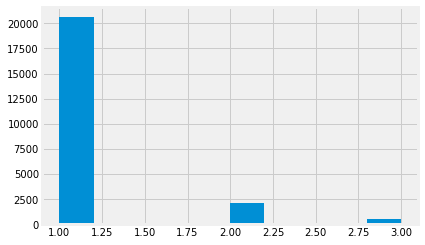

In [33]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
plt.hist(df3_ab['overall'])
plt.show

In [34]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
'''
k2, p = stats.shapiro(df_ab_g['overall'])
print(format(k2), format(p))
alpha=0.001
if float(format(p)) < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
'''

'\nk2, p = stats.shapiro(df_ab_g[\'overall\'])\nprint(format(k2), format(p))\nalpha=0.001\nif float(format(p)) < alpha:  # null hypothesis: x comes from a normal distribution\n    print("The null hypothesis can be rejected")\nelse:\n    print("The null hypothesis cannot be rejected")\n'

In [35]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
'''
len(detect_outlier(df_ab_g['overall']))
index_names = np.where(ab_z>4).index_names
df_ab_g.drop(index_names, inplace=True)
df_ab_g = df_ab_g[(np.abs(stats.zscore(df_ab_g['overall'])) < 4 ).all(axis=1)]
df_lb_g = df_lb_g[(np.abs(stats.zscore(df_lb_g['overall'])) < 4 ).all(axis=1)]
'''

"\nlen(detect_outlier(df_ab_g['overall']))\nindex_names = np.where(ab_z>4).index_names\ndf_ab_g.drop(index_names, inplace=True)\ndf_ab_g = df_ab_g[(np.abs(stats.zscore(df_ab_g['overall'])) < 4 ).all(axis=1)]\ndf_lb_g = df_lb_g[(np.abs(stats.zscore(df_lb_g['overall'])) < 4 ).all(axis=1)]\n"

In [36]:
# Temporary dataframes to use for average calculation for dataframes a and b
df_lb_avg = pd.DataFrame(df3_lb.groupby('#Weeks')['overall'].count())
df_ab_avg = pd.DataFrame(df3_ab.groupby('#Weeks')['overall'].count())

In [37]:
# Main dataframes to use for plot 1 and 2
a = pd.DataFrame(df3_lb.groupby('#Weeks')['overall'].aggregate(np.sum))
b = pd.DataFrame(df3_ab.groupby('#Weeks')['overall'].aggregate(np.sum))

In [38]:
# Calculate and add average column
a.loc[:,'avg'] = a['overall'] / df_lb_avg['overall'] 
b.loc[:,'avg'] = b['overall'] / df_ab_avg['overall']

In [39]:
# Convert values in overall to float so we can plot them
a['overall']=a['overall'].apply(to_float)
b['overall']=b['overall'].apply(to_float)

In [40]:
# Reset index for a and b for esthetic reasons
a.reset_index(inplace=True)
b.reset_index(inplace=True)

In [41]:
# Add cumulative sum column to plot a trajectory of an average product in both categories
a.loc[:,'cumsum']=a['avg'].transform(np.cumsum)
b.loc[:,'cumsum']=b['avg'].transform(np.cumsum)

In [51]:
a

,#Weeks,overall,avg,cumsum
0,0,7596.0,1.139856,1.139856
1,1,634.0,1.431151,2.571007
2,2,751.0,1.542094,4.113102
3,3,752.0,1.424242,5.537344
4,4,706.0,1.319626,6.856970
5,5,653.0,1.298211,8.155181
6,6,658.0,1.310757,9.465938
7,7,680.0,1.325536,10.791474
8,8,649.0,1.255319,12.046793
9,9,660.0,1.325301,13.372094


## Dataset for plot3

In [94]:
# reset index
df_lb.reset_index(inplace=True)
df_ab.reset_index(inplace=True)

In [95]:
#add review_year, month and day
df_lb.loc[:, "review_year"] = df_lb["DatetimeIndex"].dt.year
df_lb.loc[:, "review_month"] = df_lb["DatetimeIndex"].dt.month
df_lb.loc[:, "review_day"] = df_lb["DatetimeIndex"].dt.day

df_ab.loc[:, "review_year"] = df_ab["DatetimeIndex"].dt.year
df_ab.loc[:, "review_month"] = df_ab["DatetimeIndex"].dt.month
df_ab.loc[:, "review_day"] = df_ab["DatetimeIndex"].dt.day

In [96]:
# weight
df_lb.loc[:, "weight"] = 1
df_ab.loc[:, "weight"] = 1
# set index
df_lb.set_index(
    ["asin", "review_year", "review_month", "review_day"], inplace=True)
df_ab.set_index(["asin", "review_year", "review_month", "review_day"], inplace=True)

In [99]:
##variables in regression model 

# reviews
df_lb.loc[:, "reviews"] = df_lb.groupby(level=["asin"])["weight"].transform(
    np.cumsum)
df_ab.loc[:, "reviews"] = df_ab.groupby(level=["asin"])["weight"].transform(
    np.cumsum)
# average
df_lb.loc[:, "average"] = df_lb.groupby(level=["asin"])["overall"].transform(
    np.cumsum)
df_lb.loc[:, "average"] = df_lb["average"] / df_lb["reviews"]
df_ab.loc[:, "average"] = df_ab.groupby(level=["asin"])["overall"].transform(
    np.cumsum)
df_ab.loc[:, "average"] = df_ab["average"] / df_ab["reviews"]

/Users/zhihuipan/anaconda3/envs/Data_visualisation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [142]:
df_ab.T

asin                                                   014789302X  \
review_year                                                  2016   
review_month                                                   8    
review_day                                                     5    
index                                                           0   
DatetimeIndex                                 2016-08-05 00:00:00   
overall                                                         4   
verified                                                     True   
reviewTime                                             08 5, 2016   
reviewerID                                         A3CKVF2ZR1CBO0   
unixReviewTime                                         1470355200   
style                                                         NaN   
title           12 Pc BLUE HEAVEN KAJAL"HERBAL kajal With VITA...   
brand                                                  BLUE HEAVE   
rank                                 100,425inBeautyPersonalCare(   
main_cat                                               All Beauty   
also_view       [B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...   
also_buy        [B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...   
price                                                       $6.45   
similar_item                                                  NaN   
feature                                                       NaN   
tech1                                                         NaN   
date                                                          NaN   
start_date                                    2016-03-26 00:00:00   
end_date                                      2016-09-22 00:00:00   
#Days                                                         132   
last_review                                   2016-08-05 00:00:00   
review_gap                                                    132   
#Weeks                                                         18   
weight                                                          1   
reviews                                                         1   
average                                                         4   
cat                                                           NaN   

asin                                                               \
review_year                                                         
review_month                                                   7    
review_day                                                     29   
index                                                           1   
DatetimeIndex                                 2016-07-29 00:00:00   
overall                                                         5   
verified                                                     True   
reviewTime                                            07 29, 2016   
reviewerID                                         A3IFT6SR16SAYU   
unixReviewTime                                         1469750400   
style                                                         NaN   
title           12 Pc BLUE HEAVEN KAJAL"HERBAL kajal With VITA...   
brand                                                  BLUE HEAVE   
rank                                 100,425inBeautyPersonalCare(   
main_cat                                               All Beauty   
also_view       [B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...   
also_buy        [B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...   
price                                                       $6.45   
similar_item                                                  NaN   
feature                                                       NaN   
tech1                                                         NaN   
date                                                          NaN   
start_date                                    2016-03-26 00:00:00   
end_date                                      2016-09-22 00:00:00 

In [154]:
#concat dataframe
df_re = pd.concat([df_lb, df_ab], join='inner')

In [155]:
#creat dummy variable
dummy_cat= pd.get_dummies(df_re['main_cat'])
pd.concat([df_re, dummy_cat], axis=1) 

#also view 
df_re['no_alsoview'] = df_re['also_view'].str.len().fillna(value= 0)
#also buy
df_re['no_alsobuy'] = df_re['also_buy'].str.len().fillna(value= 0)

df_re.T

asin                                                   B00004U9V2  \
review_year                                                  2010   
review_month                                                   6    
review_day                                                     15   
index                                                           0   
DatetimeIndex                                 2010-06-15 00:00:00   
overall                                                         2   
verified                                                     True   
reviewTime                                            06 15, 2010   
reviewerID                                         A1Q6MUU0B2ZDQG   
unixReviewTime                                         1276560000   
style                                                         NaN   
title           Crabtree & Evelyn - Gardener's Ultra-Moisturis...   
also_buy        [B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...   
rank                                   4,324inBeautyPersonalCare(   
also_view       [B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...   
main_cat                                            Luxury Beauty   
price                                                      $30.00   
brand                                                    No brand   
feature                                                       NaN   
start_date                                    2010-01-07 00:00:00   
end_date                                      2010-07-06 00:00:00   
#Days                                                         159   
last_review                                   2010-06-15 00:00:00   
review_gap                                                    159   
#Weeks                                                         22   
weight                                                          1   
reviews                                                         1   
average                                                         2   
no_alsoview                                                    52   
no_alsobuy                                                     32   

asin                                                               \
review_year                                                         
review_month                                                        
review_day                                                     15   
index                                                           1   
DatetimeIndex                                 2010-06-15 00:00:00   
overall                                                         2   
verified                                                     True   
reviewTime                                            06 15, 2010   
reviewerID                                         A1Q6MUU0B2ZDQG   
unixReviewTime                                         1276560000   
style                                                         NaN   
title           Crabtree & Evelyn - Gardener's Ultra-Moisturis...   
also_buy        [B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...   
rank                                   4,324inBeautyPersonalCare(   
also_view       [B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...   
main_cat                                            Luxury Beauty   
price                                                      $30.00   
brand                                                    No brand   
feature                                                       NaN   
start_date                                    2010-01-07 00:00:00   
end_date                                      2010-07-06 00:00:00   
#Days                                                         159   
last_review                                   2010-06-15 00:00:00   
review_gap                                                    159   
#Weeks                                                         22   
weight                                                          1 

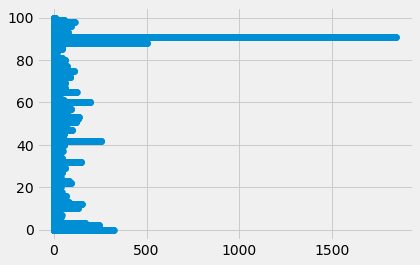

In [160]:
# check variables
plt.scatter(df_re['reviews'],df_re['no_alsobuy'])

In [161]:
# regression model
FML = "reviews ~ no_alsoview + no_alsobuy "
from statsmodels.formula.api import poisson
POISSON = smf.poisson(FML, df_re).fit()
print(POISSON.summary())

Optimization terminated successfully.
         Current function value: 56.928387
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:                reviews   No. Observations:                61359
Model:                        Poisson   Df Residuals:                    61356
Method:                           MLE   Df Model:                            2
Date:                Sun, 10 Nov 2019   Pseudo R-squ.:                  0.4110
Time:                        13:13:43   Log-Likelihood:            -3.4931e+06
converged:                       True   LL-Null:                   -5.9309e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6756      0.003    265.612      0.000       0.671       0.681
no_alsoview     0.0304   

# Plot the data 

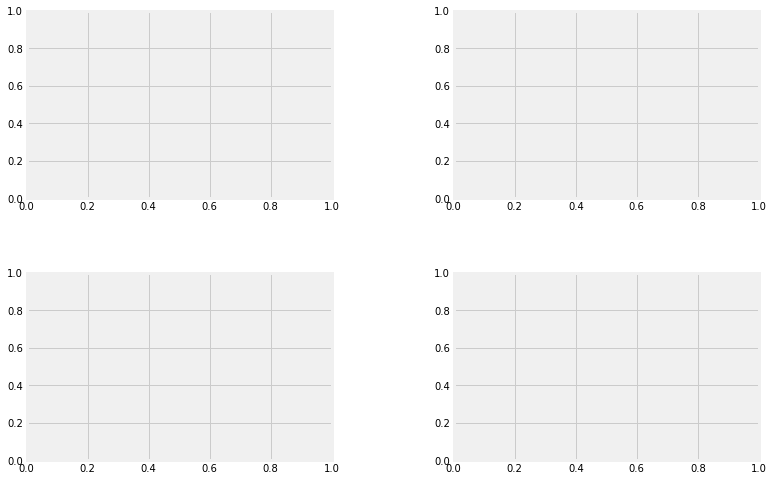

In [42]:
#Figure creation
fig = plt.figure(figsize=(11.69,8.27)) #figure size in inches to fit A4

# parition the figure into 4 subplots with 'gridspec'
gs = gridspec.GridSpec(2, 2, # we want 2 rows, 2 cols
                       figure=fig, # this gs applies to figure
                       hspace=0.4, wspace=0.4, # separation between plots
                       width_ratios=[1, 1], # ration between the first and second column
                       height_ratios=[1, 1]) # ration between the first ans second row

# add plots
ax0 = fig.add_subplot(gs[0, 0]) # this will occupy the first row-first colum
ax1 = fig.add_subplot(gs[0, 1]) # and so on and so forth...
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

In [43]:
#Plot 1
ax0.plot('#Weeks','overall',data=df3_lb,
         color='red',
         alpha=0.5,
         linewidth=0.2)
ax0.plot('#Weeks','overall',data=df3_ab,
         color='green',
         alpha=0.5,
         linewidth=0.2)

ax0.plot('#Weeks','avg',data=a,
         color='orange',
         alpha=1,
         marker='o',
         linewidth=1)
ax0.plot('#Weeks','avg',data=b,
         color='blue',
         alpha=1,
         marker='^',
         linewidth=1)


In [44]:
# Plot2
ax1.plot('cumsum', data=a,
         color='orange',
         alpha=1,
         marker='^',
         linewidth=1)
ax1.plot('cumsum', data=b,
         color='blue',
         alpha=1,
         marker='o',
         linewidth=1)

In [45]:
#Plot 4 - Association between count of ratings and average pacing between reviews
ax3.plot('average pace','overall',data=df4_lb,
         color='green',
         alpha=0.5,
         linewidth=0.2)
ax3.plot('average pace','overall',data=df4_ab,
         color='orange',
         alpha=0.5,
         linewidth=0.2)
# The average trend is not really representative right now
'''
ax3.plot('round avg pace','average count',data=df4_lb_avg,
         color='red',
         alpha=1,
         linewidth=1)
ax3.plot('round avg pace','average count',data=df4_ab_avg,
         color='blue',
         alpha=1,
         linewidth=1)
'''


"\nax3.plot('round avg pace','average count',data=df4_lb_avg,\n         color='red',\n         alpha=1,\n         linewidth=1)\nax3.plot('round avg pace','average count',data=df4_ab_avg,\n         color='blue',\n         alpha=1,\n         linewidth=1)\n"

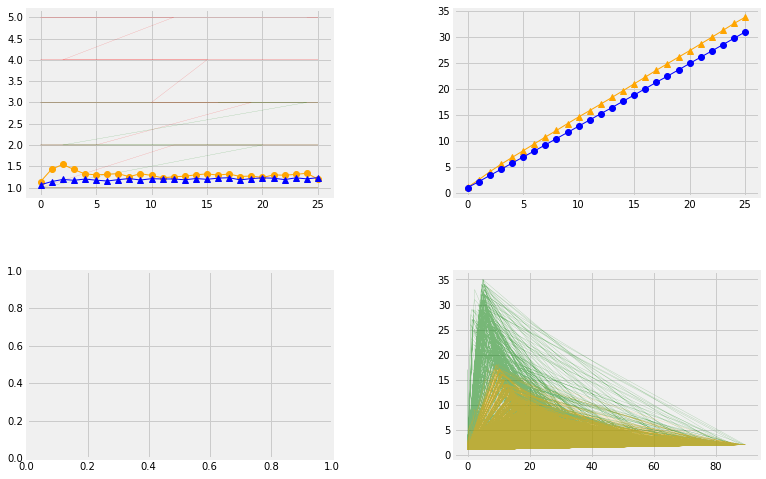

In [46]:
fig